# Pk Emulator

## PCA+GP Method

In [1]:
import pyccl as ccl
import numpy as np
import pylab as plt
import itertools

import pymaster as nmt

First we want to set up a grid of h and Omega_m spanning across our priors 

In [2]:
wc_arr  = np.linspace(0.1, 1, 10)
h_arr  = np.linspace(0.1,  1, 10)

In [3]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)

In [4]:
nk = 100 # No. of points in k
k_arr = np.logspace(-4.7,5,nk)

In [5]:
data = []
for i in range(len(wc_arr)):
    for j in range(len(h_arr)):
        cosmo = ccl.Cosmology(Omega_c=wc_arr[i], Omega_b=0.049, h=h_arr[j], sigma8=0.81, n_s=0.96)
        data.append(ccl.power.linear_matter_power(cosmo, k_arr, 1))
data = np.array(data)

In [6]:
data.shape

(100, 100)

Take log and remove mean

In [7]:
log_data = np.log(data)
log_mean_data = np.log(np.mean(data, axis=0)) #avg over all cosmologies
clean_data = log_data - log_mean_data

In [8]:
clean_data.shape

(100, 100)

Now make PCA to remove number of samples

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(np.transpose(clean_data))

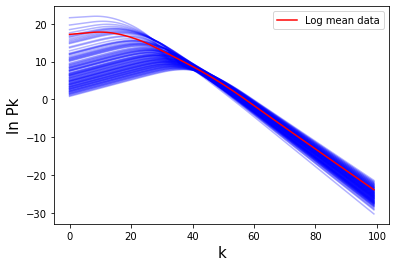

In [11]:
for i in range(len(log_data)) :   
    plt.plot( log_data[i], 'b-', alpha=0.3)
plt.plot( log_mean_data, 'r-', label='Log mean data')
plt.xlabel('k', fontsize=15)
plt.ylabel('ln Pk', fontsize=15)
plt.legend()
plt.show()

No handles with labels found to put in legend.


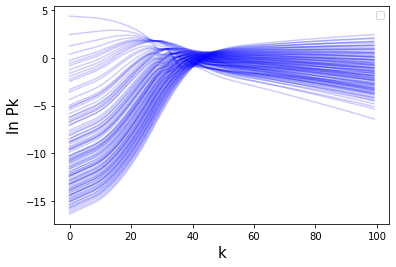

In [12]:
for i in range(len(clean_data)):
    plt.plot( clean_data[i], 'b-', alpha=0.2)
plt.xlabel('k', fontsize=15)
plt.ylabel('ln Pk', fontsize=15)
plt.legend()
plt.show()

In [13]:
 principalComponents = np.transpose( principalComponents)

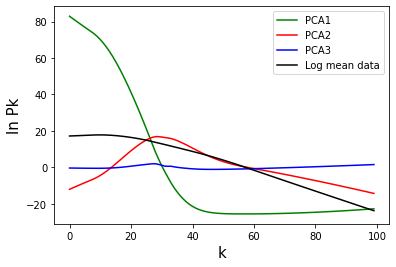

In [14]:
plt.plot( principalComponents[0], 'g-',label='PCA1')
plt.plot( principalComponents[1], 'r-',label='PCA2')
plt.plot( principalComponents[2], 'b-',label='PCA3')

plt.plot( log_mean_data, 'k-', label='Log mean data')
plt.xlabel('k', fontsize=15)
plt.ylabel('ln Pk', fontsize=15)
plt.legend()
plt.show()

Now we need to match estimates based on this PC to actual spectra - Least Squares 

In [15]:
#Define matrix y = M*w
M = np.transpose(principalComponents)
#Amplitudes
#w = np.array[[w1], [w2], [w3], [w3]]

In [16]:
M.shape

(100, 4)

In [17]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
y = ccl.power.linear_matter_power(cosmo, k_arr, 1)
y = np.log(y) - log_mean_data

In [18]:
y.shape

(100,)

In [19]:
w = np.linalg.lstsq(M, y, rcond=None)[0]

In [20]:
w

array([-0.08888304,  0.07044561,  0.0397491 ,  0.09308302])

In [21]:
def emulated_Pk(weigths , evecs, mean):
    return mean #+ np.sum(evecs*weigths, axis=1)

In [22]:
emulated = emulated_Pk(w, M, log_mean_data)
theory  = np.log(ccl.power.linear_matter_power(cosmo, k_arr, 1))

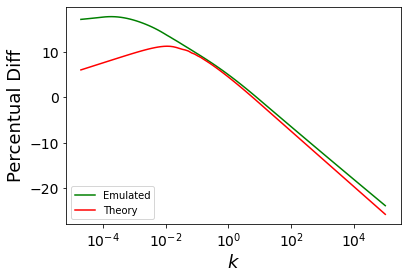

In [23]:
plt.plot(k_arr, emulated, 'g-', label = 'Emulated' )
plt.plot(k_arr, theory, 'r-', label = 'Theory' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('Percentual Diff',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.legend(loc="lower left")
plt.show()

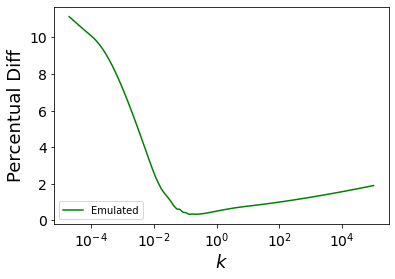

In [24]:
plt.plot(k_arr, np.abs(emulated - theory), 'g-', label = 'Emulated' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('Percentual Diff',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.legend(loc="lower left")
plt.show()

why is the emulated line consistently above the theory estimate?

Moving on to making the grid

In [25]:
w_arr = []
for i in range(len(wc_arr)):
    row = []
    for j in range(len(h_arr)):
        cosmo_ij = ccl.Cosmology(Omega_c=w_arr[i], Omega_b=0.049, h=h_arr[j], sigma8=0.81, n_s=0.96)
        y_ij = np.log(ccl.power.linear_matter_power(cosmo_ij, k_arr, 1))
        w_ij = np.linalg.lstsq(M, y_ij, rcond=None)[0]
        row.append(w_ij)
    w_arr.append(row)

data = np.array(w_arr)

IndexError: list index out of range